# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [7]:
USER_NAME = u"Шевцов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}w_j^2 = \frac{1}{N}\sum_i \log(1 + e^{-y^{(i)} g(x^{(i)})})+ \frac{1}{C}\sum_{j=1}^{m}w_j^2$$


$$ \frac{\partial L}{\partial w_i} = -\frac{1}{N}\sum_i \frac{e^{-y^{(i)} g(x^{(i)})}}{1 + e^{-y^{(i)} g(x^{(i)})}} y^{(i)} g(x^{(i)}) + \frac{1}{C}2w_i$$

## Имплементация (5 баллов)

In [125]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, batch_size = 50, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        # разделение данных на батчи
        def batches(data, batch_size=50):
            itters = len(data) / batch_size
            for i in xrange(itters):
                yield data[i*batch_size:(i+1)*batch_size]
            if (i+1)*batch_size < len(data):
                yield data[(i+1)*batch_size:]
                
        def sigma(z):
            return 1. / (1. + np.exp(-z))
        
        weights = np.zeros(X.shape[1]+1)
        data = np.c_[X, y]
        X1 = np.c_[np.ones(len(X)), X]
        alpha = self.alpha
        batch_log = []
        epoch_log = []
        batch_count = 1
        error = -np.log(sigma(X1.dot(weights))*(2*y - 1) + 1 - y).sum() / len(X)
        
        for i in xrange(self.max_epoch):
            np.random.shuffle(data)
            for batch in batches(data, self.batch_size):
 
                # вычисление градиента на шаге итерации:
                weights_grad = np.zeros((len(weights),))
                X2 = np.c_[np.ones(len(data)), data[:,:-1]]
                y1 = data[:,-1]
                reg_params = weights*2./self.C/len(data)
                reg_params[0] = 0.
                weights_grad = X2.T.dot((sigma(X2.dot(weights)) - y1)) / len(data) + reg_params
                
                # вычисление параметров: 
                weights_old = weights
                weights = weights - alpha * weights_grad
     
                error_new = -np.log(sigma(X1.dot(weights))*(2*y - 1) + 1 - y).sum() / len(X)
                if error_new < error:
                    alpha = alpha * 1.05
                else:
                    weights = weights_old
                    alpha = alpha * 0.5
                error = error_new

            epoch_log.append(-np.log(sigma(X1.dot(weights))*(2*y - 1) + 1 - y).sum() / len(X))
        
        self.batch_log_ = batch_log
        self.epoch_log_ = epoch_log
        self.weights_ = weights
        return self
    
    def get_weights(self):
        # Вывод весов модели
        return self.weights_
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return (np.c_[np.ones(len(X)),X].dot(self.weights_) > 0)*1
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        gx = np.c_[np.ones(len(X)),X].dot(self.weights_)
        sigma_gx = 1. / (1. + np.exp(-gx))
        y_hat_proba = np.c_[1 - sigma_gx, sigma_gx]
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

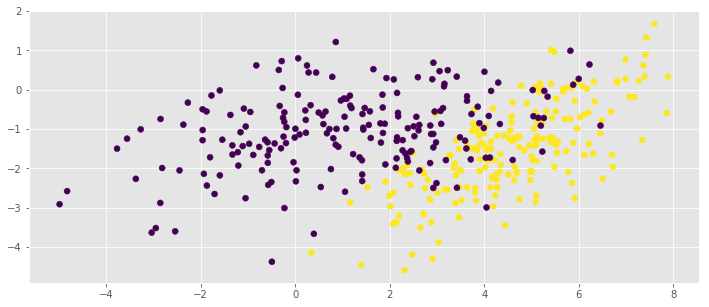

In [112]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [126]:
model = MySGDClassifier(max_epoch=180, alpha = 0.01, batch_size=200)
model.fit(X, y)
model.get_weights()

array([-6.25352847,  1.3268146 , -1.48690181])

In [128]:
y_hat = model.predict(X)

In [129]:
from sklearn.metrics import accuracy_score

In [130]:
accuracy_score(y,y_hat)

0.89249999999999996

(-4.5792962388690981, 1.6761418633126515)

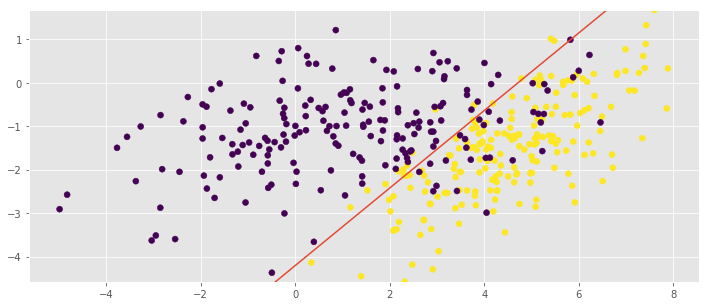

In [117]:
xx = np.linspace(X[:,0].min(), X[:,0].max())
yy = -(model.weights_[0] + model.weights_[1]*xx) / model.weights_[2]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(xx, yy)
plt.ylim(X[:,1].min(), X[:,1].max())

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [104]:
from sklearn.datasets import make_classification

In [105]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

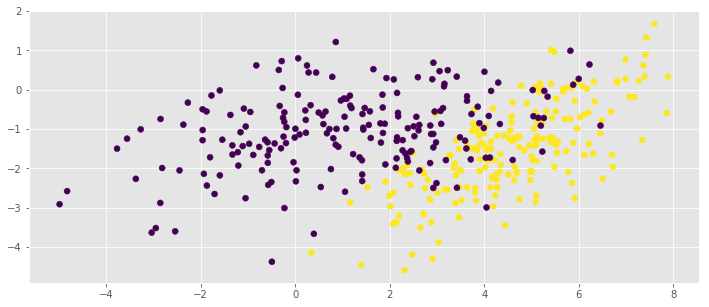

In [118]:
plt.scatter(X[:,0], X[:,1], c = y)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [138]:
## Your Code Here
model = MySGDClassifier(max_epoch=300, alpha=1.5)
model.fit(X, y)
y_y = model.epoch_log_
x_x = range(len(y_y))

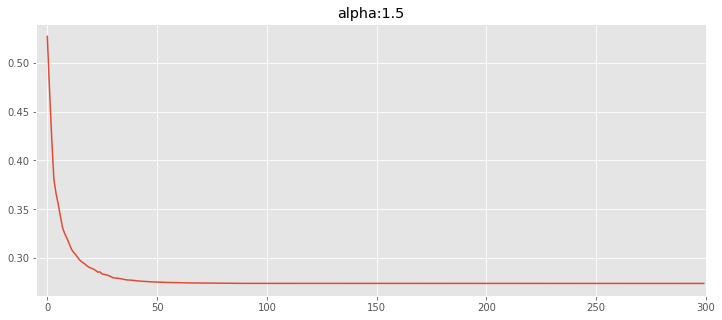

In [143]:
plt.xlim((-5,300))
plt.title('alpha:%.1f'%1.5)
plt.plot(x_x, y_y)

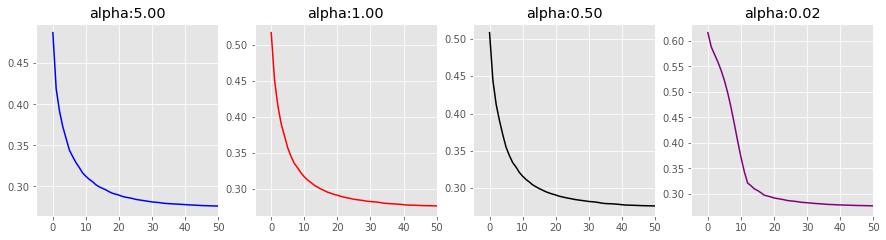

In [152]:
alphas = [5, 1, 0.5, 0.02 ]
colors = ['blue', 'red', 'black', 'purple']

plt.figure(figsize=(15, 12))
for i in range(len(alphas)):
    plt.subplot(3, 4, i+1)
    model = MySGDClassifier(max_epoch=300, alpha=alphas[i])
    model.fit(X, y)
    y_y = model.epoch_log_
    x_x = range(len(y_y))
    plt.xlim((-5,50))
    plt.title('alpha:%.2f'%alphas[i])
    plt.plot(x_x, y_y, color=colors[i])

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [155]:
C_array

array([  1.00000000e+03,   2.15443469e+02,   4.64158883e+01,
         1.00000000e+01,   2.15443469e+00,   4.64158883e-01,
         1.00000000e-01,   2.15443469e-02,   4.64158883e-03,
         1.00000000e-03])

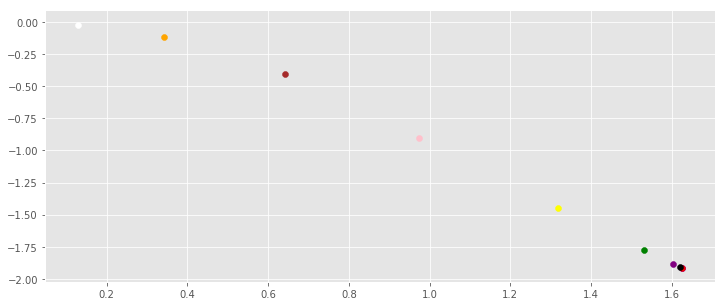

In [164]:
## Your Code Here
C_array = np.logspace(3, -3, 10)
colors = ['blue', 'red', 'black', 'purple', 'green', 'yellow', 'pink', 'brown', 'orange', 'white']

for i in range(len(C_array)):
    model = MySGDClassifier(max_epoch=300, C=C_array[i], alpha = 0.5)
    model.fit(X, y)
    #print model.get_weights()
    plt.scatter(model.get_weights()[1], model.get_weights()[2], c = colors[i])
    #y_y = model.epoch_log_
    #x_x = range(len(y_y))
    #plt.title('alpha:%.3f'%C_array[i])
    #plt.plot(x_x, y_y, color=colors[i])

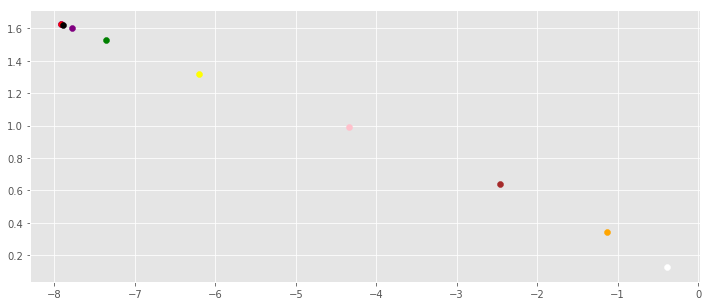

In [165]:
C_array = np.logspace(3, -3, 10)
colors = ['blue', 'red', 'black', 'purple', 'green', 'yellow', 'pink', 'brown', 'orange', 'white']

for i in range(len(C_array)):
    model = MySGDClassifier(max_epoch=300, C=C_array[i], alpha = 0.5)
    model.fit(X, y)
    #print model.get_weights()
    plt.scatter(model.get_weights()[0], model.get_weights()[1], c = colors[i])

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [167]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')
df_data = pd.read_csv('trainingData_tabular_chunk1.csv', sep=',')

In [168]:
df_data.shape

(500000, 45)

In [169]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [170]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [171]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [172]:
## Youd Code Here
from sklearn.preprocessing import OneHotEncoder

In [173]:
df_data['player_hero_card_id'].unique()

array([ 981,  754,  612,  494,   25, 1235,  326,  390,  798])

In [174]:
df_data['opponent_hero_card_id'].unique()

array([ 798,  754,  612,  390,   25, 1235,  494,  981,  326])

In [175]:
df_data = pd.get_dummies(data=df_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])
df_data = df_data.drop(['player_hero_card_id_1235', 'opponent_hero_card_id_1235'], axis=1)

In [176]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [177]:
## Youd Code Here
X = df_data.drop('decision', axis=1)
y = df_data['decision']

In [179]:
npX = np.array(X)
npy = np.array(y)

In [180]:
clf = MySGDClassifier(C = 2000, alpha=1.5, max_epoch=50)

In [181]:
clf.fit(npX, npy)

/home/anton/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


KeyboardInterrupt: 

In [ ]:
res = clf.predict_proba(X)

In [ ]:
accuracy_score(y, res)

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [3]:
## Youd Code Here
test = pd.read_csv('testData_tabular_chunk5.csv', sep=',')

test.columns = test.columns.str.replace('.', '_')
test = test.set_index('gamestate_id')
test = pd.get_dummies(data=test, columns=['player_hero_card_id', 'opponent_hero_card_id'])
test = test.drop(['player_hero_card_id_1235', 'opponent_hero_card_id_1235', 'decision'], axis=1)

In [4]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y, res)